# Finding Near real-time current data

In [1]:
import os
import sys

ioos_tools = os.path.join(os.path.pardir)
sys.path.append(ioos_tools)

In [2]:
from datetime import datetime, timedelta

# Region: West coast.
bbox = [-123, 36, -121, 40]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range: Last week.
now = datetime.utcnow()
start, stop = now - timedelta(days=(7)), now

# Surface velocity CF names.
cf_names = ['surface_northward_sea_water_velocity',
            'surface_eastward_sea_water_velocity']

In [3]:
from owslib import fes
from ioos_tools.ioos import fes_date_filter

kw = dict(wildCard='*', escapeChar='\\',
          singleChar='?', propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in cf_names])

# Exclude GNOME returns.
not_filt = fes.Not([fes.PropertyIsLike(literal='*GNOME*', **kw)])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)
filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]

In [4]:
from owslib.csw import CatalogueServiceWeb


catalogs = ['http://www.ngdc.noaa.gov/geoportal/csw',
            'https://dev-catalog.ioos.us/csw',
            'http://geoport.whoi.edu/csw']

for endpoint in catalogs:
    csw = CatalogueServiceWeb(endpoint, timeout=60)
    csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')
    records = '\n'.join(csw.records.keys())
    if records:
        print('{}\n{}\n'.format(endpoint, records))

https://dev-catalog.ioos.us/csw
hycom_global
ncep_global



We could not find any HF-Radar data there.

Let's test removing the time constraint.

In [5]:
filter_list = [fes.And([bbox_crs, or_filt, not_filt])]


for endpoint in catalogs:
    csw = CatalogueServiceWeb(endpoint, timeout=60)
    csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')
    records = '\n'.join(csw.records.keys())
    if records:
        print('{}\n{}\n'.format(endpoint, records))

http://www.ngdc.noaa.gov/geoportal/csw
HFRNet/USWC/500m/hourly/RTV
HFRNet/USWC/1km/hourly/RTV
HFRNet/USWC/2km/hourly/RTV
HFRNet/USWC/6km/hourly/RTV
HFR/USWC/1km/hourly/RTV/HFRADAR,_US_West_Coast,_1km_Resolution,_Hourly_RTV_best.ncd
HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd

https://dev-catalog.ioos.us/csw
noaa.ioos.comt:gom_hypoxia.lsu_fvcom_simpleo2_regSOC
noaa.ioos.comt:gom_hypoxia.lsu_fvcom_simpleo2_socfixedtemp
hycom_global
ncep_global
inundation_tropical.VIMS_SELFE.Hurricane_Rita_2D_final_run_without_waves
inundation_tropical.VIMS_SELFE.Hurricane_Rita_2D_final_run_with_waves
CORDC_MONTHLY
UCSC
CA_DAS



In [6]:
csw = CatalogueServiceWeb(catalogs[0], timeout=60)
csw

In [7]:
csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

In [8]:
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]: {}'.format(value.title, key))

Found 6 records.

[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
500 m Resolution]: HFRNet/USWC/500m/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: HFRNet/USWC/1km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: HFRNet/USWC/2km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
6 km Resolution]: HFRNet/USWC/6km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: HFR/USWC/1km/hourly/RTV/HFRADAR,_US_West_Coast,_1km_Resolution,_Hourly_RTV_best.ncd
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd


In [9]:
print(value.abstract)

Surface ocean velocities estimated from HF-Radar are
representative of the upper 0.3 - 2.5 meters of the
ocean.  The main objective of near-real time
processing is to produce the best product from
available data at the time of processing.  Radial
velocity measurements are obtained from individual
radar sites through the U.S. HF-Radar Network.
Hourly radial data are processed by unweighted
least-squares on a 2 km resolution grid of the U.S.
West Coast to produce near real-time surface current
maps.


https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv

In [10]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: WWW:LINK
scheme: urn:x-esri:specification:ServiceType:distribution:url
URL: http://hfrnet.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd.html

geolink: None
scheme: urn:x-esri:specification:ServiceType:distribution:url
URL: http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://hfrnet.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd

geolink: OGC:WMS
scheme: urn:x-esri:specification:ServiceType:wms:url
URL: http://hfrnet.ucsd.edu/thredds/wms/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd?service=WMS&version=1.3.0&request=GetCapabilities

geolink: OGC:WCS
scheme: urn:x-esri:specification:ServiceType:wcs:url
URL: http://hfrnet.ucsd.edu/thredds/wcs/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd?service=WCS&version=1.0.0&request=GetCapabilities

geolink: None
scheme: urn:x-esri:s

# Add scheme explanation and links to the available schemes

In [11]:
url = value.references[4]['url']
url

'http://hfrnet.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd'

In [12]:
import xarray as xr

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:       (lat: 1099, lon: 700, nProcParam: 7, nSites: 49, time: 44973)
Coordinates:
  * lat           (lat) float32 30.25 30.268 30.286 30.3039 30.3219 30.3399 ...
  * lon           (lon) float32 -130.36 -130.339 -130.318 -130.298 -130.277 ...
  * time          (time) datetime64[ns] 2011-10-01 2011-10-01T01:00:00 ...
    time_run      (time) datetime64[ns] ...
  * nSites        (nSites) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * nProcParam    (nProcParam) int64 0 1 2 3 4 5 6
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version

In [13]:
from datetime import date, timedelta

yesterday = date.today() - timedelta(days=1)

ds = ds.sel(time=yesterday)

In [14]:
import numpy.ma as ma

u = ds['u'].data
v = ds['v'].data

lon = ds.coords['lon'].data
lat = ds.coords['lat'].data
time = ds.coords['time'].data

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

In [15]:
import numpy as np
from oceans import uv2spdir, spdir2uv

angle, speed = uv2spdir(u, v)
us, vs = spdir2uv(np.ones_like(speed), angle, deg=True)

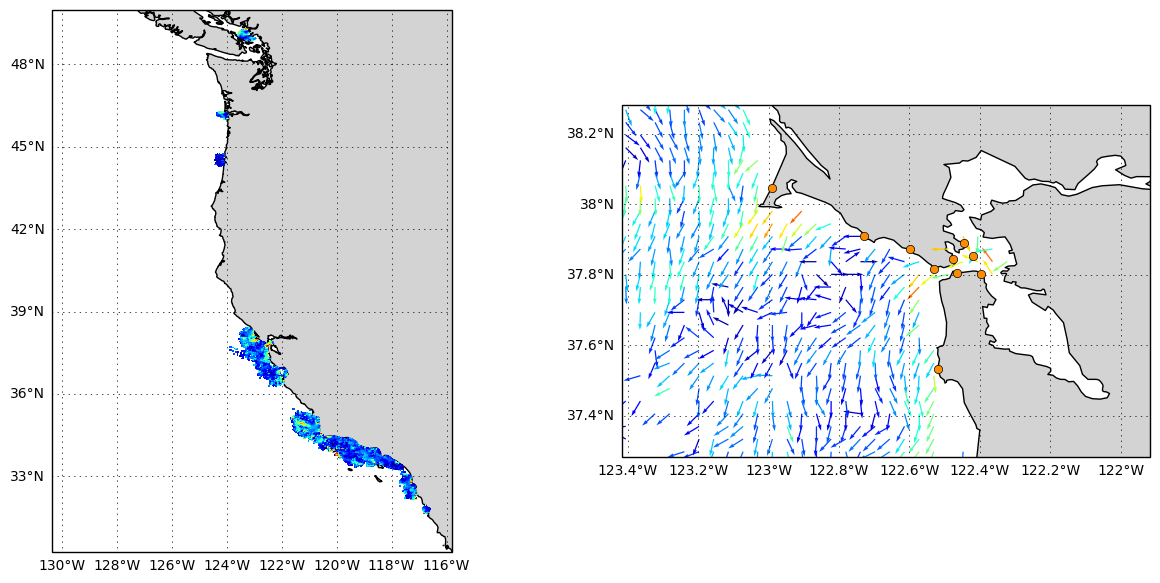

In [16]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = feature.NaturalEarthFeature('physical', 'land', '10m',
                                   edgecolor='face',
                                   facecolor='lightgray')

sub = 2
dx = dy = 0.5
center = -122.416667, 37.783333  # San Francisco.
bbox = lon.min(), lon.max(), lat.min(), lat.max()

fig, (ax0, ax1) = plt.subplots(ncols=2,
    figsize=(15, 7),
    subplot_kw=dict(projection=(ccrs.PlateCarree()))
)


ax0.set_extent(bbox)
ax0.pcolormesh(lon, lat, ma.masked_invalid(speed))
gl = ax0.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax0.add_feature(LAND, zorder=0, edgecolor='black')


ax1.set_extent([center[0]-dx-dx, center[0]+dx, center[1]-dy, center[1]+dy])
ax1.quiver(lon[::sub], lat[::sub],
           us[::sub, ::sub], vs[::sub, ::sub],
           speed[::sub, ::sub], scale=30)
gl = ax1.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(LAND, zorder=0, edgecolor='black')
ax1.plot(ds['site_lon'], ds['site_lat'], marker='o', linestyle='none', color='darkorange')